<div class="alert alert-info">
    <h1>How Do Changes in Calibration and Image Processing Affect Results?</h1>
Robert S. French, rfrench@seti.org - Last updated April 24, 2023

<h2>The Problem</h2>

1) French (2012) used inconsistently-calibrated images. Observations through ISS_041RF_FMOVIE001_VIMS
   used CISSCAL 3.3. Observations after that used CISSCAL 3.6. The current work uses CISSCAL 4.0beta.
   
2) French (2012) used radial extents from 138,465-141,835. The current work uses 139,223-141,223.

3) French (2012) used old image processing software to take one radial slice per image. 
   - The slice was taken at the point of least ring curvature and covered an inconsistent amount of longitude.
     The EW for an entire observations was the mean (+/- std dev) of those radial slices.
   - The normal EW was computed by applying a single mean emission angle to all radial slices in an observation.
   - The current work uses image reprojection and mosaicing to create a rectangular grid of longitude/radius.
     This process could potentially introduce changes in photometry. 
   - Longitudes are sampled at intervals of 0.02 degrees. The EW for an entire observation is the mean
     (+/- std dev) of these radial slices. 
   - The normal EW is computed on a slice-by-slice basis by looking at the emission angle for that particular
     slice.
   - There are many more radial slices than in French (2012), resulting in more thorough coverage of the
     variability of the ring.
   
<h2>Methodology</h2>

Compare French (2012) to Current Data
- Use the same 25 F ring observations used in 2012
- Compare the EWs between French (2012) results and current results
- Use individual images to check on calibration differences with different versions. Apply those
  differences to the data to see if changes in calibration totally account for measurement differences.
- To check on the photometric accuracy of reprojections, try various combinations of radius and longitude
  zoom during reprojection.
</div>

# Read Data and Initialize Data Structures

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Read the new data and populate the old data
obsdata = pd.read_csv('../data_files/cass_ew_60_0.csv', parse_dates=['Date'], index_col='Observation')
time0 = np.datetime64('1970-01-01T00:00:00') # Epoch
obsdata['Date_days'] = (obsdata['Date']-time0).dt.total_seconds()/86400

# These EWs are raw, not adjusted for emission angle
data2012_dict = {
    'ISS_000RI_SATSRCHAP001_PRIME': [ 2.6, 0.8],
    'ISS_00ARI_SPKMOVPER001_PRIME': [ 3.1, 0.6],
    'ISS_006RI_LPHRLFMOV001_PRIME': [ 4.7, 0.9],
    'ISS_007RI_LPHRLFMOV001_PRIME': [ 1.5, 0.3],
    'ISS_029RF_FMOVIE001_VIMS':     [12.6, 2.7],
    'ISS_031RF_FMOVIE001_VIMS':     [10.3, 1.4],
    'ISS_032RF_FMOVIE001_VIMS':     [ 9.9, 1.8],
    'ISS_033RF_FMOVIE001_VIMS':     [12.9, 1.7],
    'ISS_036RF_FMOVIE001_VIMS':     [13.6, 5.3],
    'ISS_036RF_FMOVIE002_VIMS':     [ 2.9, 2.2],
    'ISS_039RF_FMOVIE002_VIMS':     [ 2.7, 1.7],
    'ISS_039RF_FMOVIE001_VIMS':     [ 1.7, 1.0],
    'ISS_041RF_FMOVIE002_VIMS':     [ 1.8, 1.0],
    'ISS_041RF_FMOVIE001_VIMS':     [ 2.1, 0.9],
    'ISS_044RF_FMOVIE001_VIMS':     [ 2.4, 0.9],
    'ISS_051RI_LPMRDFMOV001_PRIME': [ 8.1, 1.6],
    'ISS_055RF_FMOVIE001_VIMS':     [ 1.3, 0.3],
    'ISS_055RI_LPMRDFMOV001_PRIME': [ 3.2, 0.5],
    'ISS_057RF_FMOVIE001_VIMS':     [ 1.3, 0.3],
    'ISS_068RF_FMOVIE001_VIMS':     [ 0.9, 0.1],
    'ISS_075RF_FMOVIE002_VIMS':     [ 1.2, 0.2],
    'ISS_083RI_FMOVIE109_VIMS':     [ 1.9, 0.6],
    'ISS_087RF_FMOVIE003_PRIME':    [ 0.9, 0.2],
    'ISS_089RF_FMOVIE003_PRIME':    [ 1.0, 0.2],
    'ISS_100RF_FMOVIE003_PRIME':    [ 0.8, 0.1]
}
data2012_obsname = data2012_dict.keys() 
data2012_ew = [x[0] for x in data2012_dict.values()]
data2012_std = [x[1] for x in data2012_dict.values()]
data2012 = pd.DataFrame({'EW Mean': data2012_ew, 
                         'EW Std':  data2012_std},
                        index=data2012_obsname)

# Find the intersection of the old and new data
# This should be the same number of observations as the old data
commondata = obsdata.join(data2012, on='Observation', how='inner', rsuffix='_2012')

# Compute the normal EW by adjusting by the mean emission angle in the new data
commondata['Normal EW Mean_2012'] = commondata['EW Mean_2012'] * np.abs(
        np.cos(np.radians(commondata['Mean Emission'])))

# Compute the ratios between the new and old data (these should be approximately the same)
commondata['EW Mean Ratio'] = commondata['EW Mean']/commondata['EW Mean_2012']
commondata['Normal EW Mean Ratio'] = commondata['Normal EW Mean']/commondata['Normal EW Mean_2012']
print('Total number of new observation names:', len(obsdata))
print('Total number of observation names from 2012:', len(data2012))
print('Number of observation names in common:', len(commondata))

Total number of new observation names: 201
Total number of observation names from 2012: 25
Number of observation names in common: 24


# Compare French (2012) EWs with Current EWs

In [3]:
# Extract measurements from each CISSCAL version range
commondata33 = commondata.loc[:'ISS_041RF_FMOVIE002_VIMS']
commondata36 = commondata.loc['ISS_044RF_FMOVIE001_VIMS':]

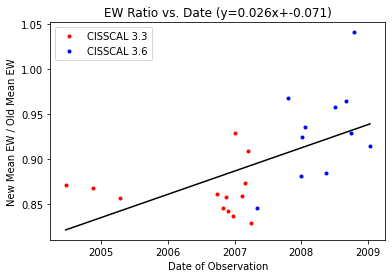

In [24]:
coeff = np.polyfit(commondata['Date_days'], commondata['EW Mean Ratio'], 1)
date_min = commondata['Date_days'].min()
date_max = commondata['Date_days'].max()
plt.plot([date_min,date_max], np.polyval(coeff, [date_min,date_max]), '-',
         color='black')
plt.plot(commondata33['Date'], commondata33['EW Mean Ratio'], '.', 
         color='red', label='CISSCAL 3.3')
plt.plot(commondata36['Date'], commondata36['EW Mean Ratio'], '.', 
         color='blue', label='CISSCAL 3.6')
plt.legend()
plt.xlabel('Date of Observation')
plt.ylabel('New Mean EW / Old Mean EW')
_=plt.title(f'EW Ratio vs. Date (y={coeff[0]*365.25:.3f}x+{coeff[1]:.3f})')

In [5]:
print('How much was EW affected by CISSCAL version?')
c33_mean = commondata33['EW Mean Ratio'].mean()
c36_mean = commondata36['EW Mean Ratio'].mean()
overall_mean = commondata['EW Mean Ratio'].mean()
print(f'  CISSCAL 3.3 obs only - Mean New/Old EW: {c33_mean:.3f}')
print(f'  CISSCAL 3.6 obs only - Mean New/Old EW: {c36_mean:.3f}')
print(f'              All Data - Mean New/Old EW: {overall_mean:.3f}')

How much was EW affected by CISSCAL version?
  CISSCAL 3.3 obs only - Mean New/Old EW: 0.864
  CISSCAL 3.6 obs only - Mean New/Old EW: 0.931
              All Data - Mean New/Old EW: 0.895


<div class="alert alert-info">
<h2>Conclusion</h2>

<b>Images calibrated with CISSCAL 4.0 will appear ~10% *dimmer* than previously calibrated images. Since we measured
a brightening in the F ring using previous versions of CISSCAL, that amount of brightening will now be less.
The difference in CISSCAL versions shows a distinct time dependence, with the more recent 3.6 converging
on the new 4.0.</b>
</div>

# Compare Individual Images Calibrated with CISSCAL 3.3/3.6 to 4.0

In [13]:
# These are the images used to compare calibrations. Each is either the first or last
# image used in the 2012 paper for each observation name.
# image_versions = (
#     ('N1466448701_1_CALIB-3.3.IMG', 'N1466448701_1_CALIB-4.0.IMG'), # ISS_000RI_SATSRCHAP001_PRIME
#     ('N1479201492_1_CALIB-3.3.IMG', 'N1479201492_1_CALIB-4.0.IMG'), # ISS_00ARI_SPKMOVPER001_PRIME
#     ('N1492052646_1_CALIB-3.3.IMG', 'N1492052646_1_CALIB-4.0.IMG'), # ISS_006RI_LPHRLFMOV001_PRIME
#     ('N1493613276_1_CALIB-3.3.IMG', 'N1493613276_1_CALIB-4.0.IMG'), # ISS_007RI_LPHRLFMOV001_PRIME
#     ('N1538168640_1_CALIB-3.3.IMG', 'N1538168640_1_CALIB-4.0.IMG'), # ISS_029RF_FMOVIE001_VIMS
#     ('N1541012989_1_CALIB-3.3.IMG', 'N1541012989_1_CALIB-4.0.IMG'), # ISS_031RF_FMOVIE001_VIMS
#     ('N1542047155_1_CALIB-3.3.IMG', 'N1542047155_1_CALIB-4.0.IMG'), # ISS_032RF_FMOVIE001_VIMS
#     ('N1543166702_1_CALIB-3.3.IMG', 'N1543166702_1_CALIB-4.0.IMG'), # ISS_033RF_FMOVIE001_VIMS
#     ('N1545556618_1_CALIB-3.3.IMG', 'N1545556618_1_CALIB-4.0.IMG'), # ISS_036RF_FMOVIE001_VIMS
#     ('N1546748805_1_CALIB-3.3.IMG', 'N1546748805_1_CALIB-4.0.IMG'), # ISS_036RF_FMOVIE002_VIMS
#     ('N1549801218_1_CALIB-3.3.IMG', 'N1549801218_1_CALIB-4.0.IMG'), # ISS_039RF_FMOVIE002_VIMS
#     ('N1551253524_1_CALIB-3.3.IMG', 'N1551253524_1_CALIB-4.0.IMG'), # ISS_039RF_FMOVIE001_VIMS
#     ('N1552790437_1_CALIB-3.3.IMG', 'N1552790437_1_CALIB-4.0.IMG'), # ISS_041RF_FMOVIE002_VIMS
#     ('N1554026927_1_CALIB-3.3.IMG', 'N1554026927_1_CALIB-4.0.IMG'), # ISS_041RF_FMOVIE001_VIMS

#     ('N1557020880_1_CALIB-3.6.IMG', 'N1557020880_1_CALIB-4.0.IMG'), # ISS_044RF_FMOVIE001_VIMS
#     ('N1571435192_1_CALIB-3.6.IMG', 'N1571435192_1_CALIB-4.0.IMG'), # ISS_051RI_LPMRDFMOV001_PRIME
#     ('N1577809417_1_CALIB-3.6.IMG', 'N1577809417_1_CALIB-4.0.IMG'), # ISS_055RF_FMOVIE001_VIMS
#     ('N1578386361_1_CALIB-3.6.IMG', 'N1578386361_1_CALIB-4.0.IMG'), # ISS_055RI_LPMRDFMOV001_PRIME
#     ('N1579790806_1_CALIB-3.6.IMG', 'N1579790806_1_CALIB-4.0.IMG'), # ISS_057RF_FMOVIE001_VIMS
#     ('N1589589182_1_CALIB-3.6.IMG', 'N1589589182_1_CALIB-4.0.IMG'), # ISS_068RF_FMOVIE001_VIMS
#     ('N1593913221_1_CALIB-3.6.IMG', 'N1593913221_1_CALIB-4.0.IMG'), # ISS_075RF_FMOVIE002_VIMS
#     ('N1598806665_1_CALIB-3.6.IMG', 'N1598806665_1_CALIB-4.0.IMG'), # ISS_083RI_FMOVIE109_VIMS
#     ('N1601485634_1_CALIB-3.6.IMG', 'N1601485634_1_CALIB-4.0.IMG'), # ISS_087RF_FMOVIE003_PRIME
#     ('N1602717403_1_CALIB-3.6.IMG', 'N1602717403_1_CALIB-4.0.IMG'), # ISS_089RF_FMOVIE003_PRIME
#     ('N1610364098_1_CALIB-3.6.IMG', 'N1610364098_1_CALIB-4.0.IMG'), # ISS_100RF_FMOVIE003_PRIME
# )

# The ratio of the medians of new / old. The medians are computed using only the pixel values with
# ring radii 139820-140620, to cover the range of +/- 400km from the nominal core semi-major axis
# (a*e = 329 km)
# These are generated using the program utilities/compare_cisscal_versions.py
cisscal_ratio_dict = { # CISSCAL 4.0 / CISSCAL 3.3-3.6 median ratio for one image
    # New / old ratio
    # CISSCAL 3.3
    'ISS_000RI_SATSRCHAP001_PRIME': 0.874,
    'ISS_00ARI_SPKMOVPER001_PRIME': 0.868,
    'ISS_006RI_LPHRLFMOV001_PRIME': 0.870,
    'ISS_007RI_LPHRLFMOV001_PRIME': 0.851,
    'ISS_029RF_FMOVIE001_VIMS':     0.910,
    'ISS_031RF_FMOVIE001_VIMS':     0.884,
    'ISS_032RF_FMOVIE001_VIMS':     0.883,
    'ISS_033RF_FMOVIE001_VIMS':     1.014,
    'ISS_036RF_FMOVIE001_VIMS':     0.889,
    'ISS_036RF_FMOVIE002_VIMS':     0.888,
    'ISS_039RF_FMOVIE002_VIMS':     0.895,
    'ISS_039RF_FMOVIE001_VIMS':     0.886,
    'ISS_041RF_FMOVIE002_VIMS':     0.896,
    'ISS_041RF_FMOVIE001_VIMS':     0.979,
    # CISSCAL 3.6 from here on
    'ISS_044RF_FMOVIE001_VIMS':     0.949,
    'ISS_051RI_LPMRDFMOV001_PRIME': 1.086,
    'ISS_055RF_FMOVIE001_VIMS':     0.979,
    'ISS_055RI_LPMRDFMOV001_PRIME': 0.929,
    'ISS_057RF_FMOVIE001_VIMS':     0.979,
    'ISS_068RF_FMOVIE001_VIMS':     0.992,
    'ISS_075RF_FMOVIE002_VIMS':     0.979,
    'ISS_083RI_FMOVIE109_VIMS':     0.938,
    'ISS_087RF_FMOVIE003_PRIME':    0.936,
    'ISS_089RF_FMOVIE003_PRIME':    0.936,
    'ISS_100RF_FMOVIE003_PRIME':    0.952
}
cr_obsname = cisscal_ratio_dict.keys() 
cr_ratio = cisscal_ratio_dict.values()
cr_data = pd.DataFrame({'CISSCAL Ratio': cr_ratio}, index=cr_obsname)
commondata = commondata.join(cr_data, on='Observation', how='inner', rsuffix='_old')
commondata33 = commondata.loc[:'ISS_041RF_FMOVIE002_VIMS']
commondata36 = commondata.loc['ISS_044RF_FMOVIE001_VIMS':]
print('Number of old observations:', len(cr_obsname))
print('Number of common observations:', len(commondata))
print('CISSCAL 3.6 starts at', commondata.loc['ISS_044RF_FMOVIE001_VIMS']['Date'])
print('Number of CISSCAL 3.3 observations:', len(commondata33))
print('Number of CISSCAL 3.6 observations:', len(commondata36))
print('Answering the question: Does adjusting by the CISSCAL ratio fully account for the EW ratio?')
print('Looking at (EW_new / EW_2012) / (CISSCAL_new / CISSCAL_2012):')
cratio = (commondata['EW Mean Ratio']/commondata['CISSCAL Ratio']).mean()
cratio33 = (commondata33['EW Mean Ratio']/commondata33['CISSCAL Ratio']).mean()
cratio36 = (commondata36['EW Mean Ratio']/commondata36['CISSCAL Ratio']).mean()
print(f'  Mean all obs: {cratio:.3f}')
print(f'  Mean 3.3 obs: {cratio33:.3f}')
print(f'  Mean 3.6 obs: {cratio36:.3f}')

Number of old observations: 25
Number of common observations: 24
CISSCAL 3.6 starts at 2007-05-05 04:51:11
Number of CISSCAL 3.3 observations: 13
Number of CISSCAL 3.6 observations: 11
Answering the question: Does adjusting by the CISSCAL ratio fully account for the EW ratio?
Looking at (EW_new / EW_2012) / (CISSCAL_new / CISSCAL_2012):
  Mean all obs: 0.961
  Mean 3.3 obs: 0.960
  Mean 3.6 obs: 0.963


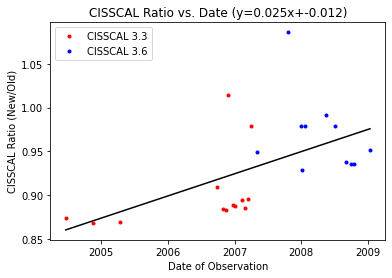

In [26]:
coeff = np.polyfit(commondata['Date_days'], commondata['CISSCAL Ratio'], 1)
date_min = commondata['Date_days'].min()
date_max = commondata['Date_days'].max()
plt.plot([date_min,date_max], np.polyval(coeff, [date_min,date_max]), '-',
         color='black')
plt.plot(commondata33['Date'], commondata33['CISSCAL Ratio'], '.', 
         color='red', label='CISSCAL 3.3')
plt.plot(commondata36['Date'], commondata36['CISSCAL Ratio'], '.', 
         color='blue', label='CISSCAL 3.6')
plt.legend()
plt.xlabel('Date of Observation')
plt.ylabel('CISSCAL Ratio (New/Old)')
_=plt.title(f'CISSCAL Ratio vs. Date (y={coeff[0]*365.25:.3f}x+{coeff[1]:.3f})')

<div class="alert alert-info">
<h2>Conclusion</h2>
    
<b>The changes in CISSCAL show approximately the same time dependence as the changes in EW above.</b>
    
<b>Adjusting for changes in CISSCAL ratio accounts for all but ~4% of the difference between 2012 and current
    EW data. This means that the changes in radial extent and reprojection/mosaicing only account for a 4%
    difference, which is negligible.</b>
</div>

# Compare 2012 EWs Adjusted for CISSCAL Ratios to Current EWs

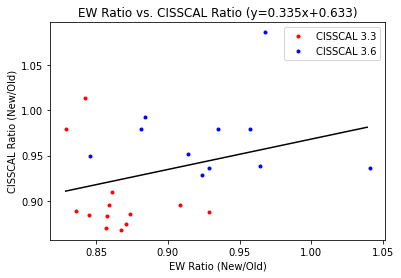

In [16]:
coeff = np.polyfit(commondata['EW Mean Ratio'], commondata['CISSCAL Ratio'], 1)
ewr_min = commondata['EW Mean Ratio'].min()
ewr_max = commondata['EW Mean Ratio'].max()
plt.plot(commondata33['EW Mean Ratio'], commondata33['CISSCAL Ratio'], '.', 
         color='red', label='CISSCAL 3.3')
plt.plot(commondata36['EW Mean Ratio'], commondata36['CISSCAL Ratio'], '.', 
         color='blue', label='CISSCAL 3.6')
xrange = np.arange(ewr_min, ewr_max, 0.01)
plt.plot(xrange, np.polyval(coeff, xrange), '-',
         color='black')
plt.legend()
plt.xlabel('EW Ratio (New/Old)')
plt.ylabel('CISSCAL Ratio (New/Old)')
_=plt.title(f'EW Ratio vs. CISSCAL Ratio (y={coeff[0]:.3f}x+{coeff[1]:.3f})')

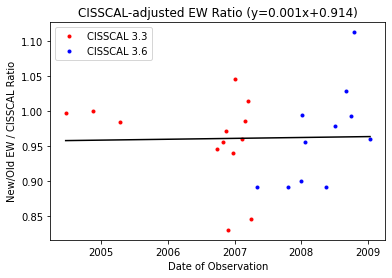

In [21]:
coeff = np.polyfit(commondata['Date_days'],
                   commondata['EW Mean Ratio'] / commondata['CISSCAL Ratio'], 1)
date_min = commondata['Date_days'].min()
date_max = commondata['Date_days'].max()
plt.plot(commondata33['Date'], commondata33['EW Mean Ratio'] / commondata33['CISSCAL Ratio'], '.',
         color='red', label='CISSCAL 3.3')
plt.plot(commondata36['Date'], commondata36['EW Mean Ratio'] / commondata36['CISSCAL Ratio'], '.',
         color='blue', label='CISSCAL 3.6')
plt.plot([date_min,date_max], np.polyval(coeff, [date_min,date_max]), '-',
         color='black')
plt.legend()
plt.xlabel('Date of Observation')
plt.ylabel('New/Old EW / CISSCAL Ratio')
_=plt.title(f'CISSCAL-adjusted EW Ratio (y={coeff[0]*365.25:.3f}x+{coeff[1]:.3f})')

<div class="alert alert-info">
<h2>Conclusion</h2>
    
<b>EW Ratio and CISSCAL ratio are clearly correlated, as you would expect if the CISSCAL change was the primary
    driver of the EW change.</b>
    
<b>Once the EWs are adjusted for mean changes in CISSCAL, the result shows no
    time dependence. The mean result is the expected ~4% dimmer than actual current results.</b>
</div>

# Compare Old/New EW with Phase Curves

### Use All Common Data Points

** Statistics - ratio of phase curves including outliers
Ratio min: 0.8508316431344536
Ratio max: 0.928680875887054
Ratio mean: 0.8846054141276566
Ratio median: 0.8821137427610294


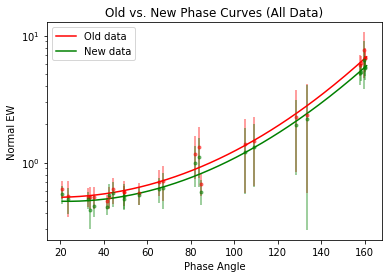

In [8]:
xrange = np.arange(commondata['Mean Phase'].min(), commondata['Mean Phase'].max()+1)
commondata['Normal EW_old'] = (commondata['EW_old'] * 
                               np.abs(np.cos(np.radians(commondata['Mean Emission']))))
commondata['Normal EW Std_old'] = (commondata['EW Std_old'] * 
                                   np.abs(np.cos(np.radians(commondata['Mean Emission']))))
plt.errorbar(commondata['Mean Phase'], commondata['Normal EW_old'], 
             yerr=commondata['Normal EW Std_old'], fmt='.', color='red', alpha=0.5)
plt.errorbar(commondata['Mean Phase'], commondata['Normal EW'], 
             yerr=commondata['Normal EW Std'], fmt='.', color='green', alpha=0.5)
# 2012 paper used log-cubic phase curve
coeff_old = np.polyfit(commondata['Mean Phase'], np.log10(commondata['Normal EW_old']), 3)
coeff_new = np.polyfit(commondata['Mean Phase'], np.log10(commondata['Normal EW']), 3)
phase_model_old = 10**np.polyval(coeff_old, xrange)
phase_model_new = 10**np.polyval(coeff_new, xrange)
plt.plot(xrange, phase_model_old, '-', color='red', label='Old data')
plt.plot(xrange, phase_model_new, '-', color='green', label='New data')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle')
plt.ylabel('Normal EW')
plt.title('Old vs. New Phase Curves (All Data)')
phase_curve_ratio = phase_model_new / phase_model_old
print('** Statistics - ratio of phase curves including outliers')
print('Ratio min:', phase_curve_ratio.min())
print('Ratio max:', phase_curve_ratio.max())
print('Ratio mean:', phase_curve_ratio.mean())
print('Ratio median:', np.median(phase_curve_ratio))

** Statistics - ratio of CISSCAL-adjusted phase curves including outliers
Ratio min: 0.923614388454892
Ratio max: 1.027553058928209
Ratio mean: 0.9633632803176192
Ratio median: 0.9624507901743596


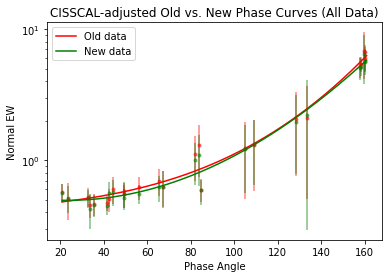

In [9]:
plt.errorbar(commondata['Mean Phase'], 
             commondata['Normal EW_old'] * commondata['CISSCAL Ratio'], 
             yerr=commondata['Normal EW Std_old'] * commondata['CISSCAL Ratio'], 
             fmt='.', color='red', alpha=0.5)
plt.errorbar(commondata['Mean Phase'], 
             commondata['Normal EW'], 
             yerr=commondata['Normal EW Std'], 
             fmt='.', color='green', alpha=0.5)
coeff_old = np.polyfit(commondata['Mean Phase'], 
                       np.log10(commondata['Normal EW_old'] * commondata['CISSCAL Ratio']), 3)
coeff_new = np.polyfit(commondata['Mean Phase'], 
                       np.log10(commondata['Normal EW']), 3)
phase_model_old = 10**np.polyval(coeff_old, xrange)
phase_model_new = 10**np.polyval(coeff_new, xrange)
plt.plot(xrange, phase_model_old, '-', color='red', label='Old data')
plt.plot(xrange, phase_model_new, '-', color='green', label='New data')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle')
plt.ylabel('Normal EW')
plt.title('CISSCAL-adjusted Old vs. New Phase Curves (All Data)')
phase_curve_ratio = phase_model_new / phase_model_old
print('** Statistics - ratio of CISSCAL-adjusted phase curves including outliers')
print('Ratio min:', phase_curve_ratio.min())
print('Ratio max:', phase_curve_ratio.max())
print('Ratio mean:', phase_curve_ratio.mean())
print('Ratio median:', np.median(phase_curve_ratio))

In [10]:
ew_ratio = commondata['Normal EW'] / commondata['Normal EW_old']
print('** Statistics - ratio of data points including outliers')
print('Ratio min:', ew_ratio.min())
print('Ratio max:', ew_ratio.max())
print('Ratio mean:', ew_ratio.mean())
print('Ratio median:', ew_ratio.median())

** Statistics - ratio of data points including outliers
Ratio min: 0.7898891016223138
Ratio max: 1.041535023813049
Ratio mean: 0.8892474791166505
Ratio median: 0.8725300798487481


### Exclude Outliers

In [11]:
limited_commondata = commondata[commondata.index != 'ISS_041RF_FMOVIE001_VIMS']
limited_commondata = limited_commondata[limited_commondata.index != 'ISS_044RF_FMOVIE001_VIMS']
limited_commondata = limited_commondata[limited_commondata.index != 'ISS_00ARI_SPKMOVPER001_PRIME']
print('Number of observation names after removing outliers:', len(limited_commondata))

Number of observation names after removing outliers: 22


** Statistics - ratio of phase curves excluding outliers
Ratio min: 0.8475939991983373
Ratio max: 0.9165512323384758
Ratio mean: 0.8957680581551112
Ratio median: 0.9029028589632216


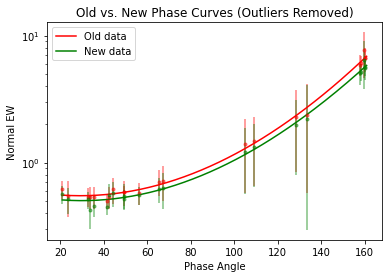

In [12]:
plt.errorbar(limited_commondata['Mean Phase'], limited_commondata['Normal EW_old'], 
             yerr=limited_commondata['Normal EW Std_old'], fmt='.', color='red', alpha=0.5)
plt.errorbar(limited_commondata['Mean Phase'], limited_commondata['Normal EW'], 
             yerr=limited_commondata['Normal EW Std'], fmt='.', color='green', alpha=0.5)
limited_coeff_old = np.polyfit(limited_commondata['Mean Phase'], 
                               np.log10(limited_commondata['Normal EW_old']), 3)
limited_coeff_new = np.polyfit(limited_commondata['Mean Phase'], 
                               np.log10(limited_commondata['Normal EW']), 3)
limited_phase_model_old = 10**np.polyval(limited_coeff_old, xrange)
limited_phase_model_new = 10**np.polyval(limited_coeff_new, xrange)
plt.plot(xrange, limited_phase_model_old, '-', color='red', label='Old data')
plt.plot(xrange, limited_phase_model_new, '-', color='green', label='New data')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle')
plt.ylabel('Normal EW')
plt.title('Old vs. New Phase Curves (Outliers Removed)')
limited_phase_curve_ratio = limited_phase_model_new / limited_phase_model_old
print('** Statistics - ratio of phase curves excluding outliers')
print('Ratio min:', limited_phase_curve_ratio.min())
print('Ratio max:', limited_phase_curve_ratio.max())
print('Ratio mean:', limited_phase_curve_ratio.mean())
print('Ratio median:', np.median(limited_phase_curve_ratio))


** Statistics - ratio of phase curves excluding outliers
Ratio min: 0.9203124613250854
Ratio max: 1.0143427359324897
Ratio mean: 0.9749888089252
Ratio median: 0.9748380155079451


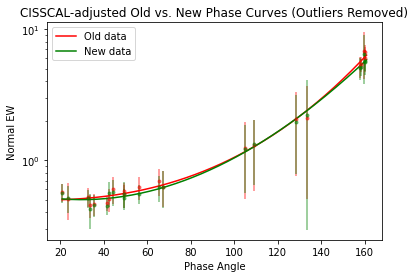

In [13]:
plt.errorbar(limited_commondata['Mean Phase'], 
             limited_commondata['Normal EW_old'] * limited_commondata['CISSCAL Ratio'], 
             yerr=limited_commondata['Normal EW Std_old'] *
                  limited_commondata['CISSCAL Ratio'], 
             fmt='.', color='red', alpha=0.5)
plt.errorbar(limited_commondata['Mean Phase'], 
             limited_commondata['Normal EW'], 
             yerr=limited_commondata['Normal EW Std'], 
             fmt='.', color='green', alpha=0.5)
limited_coeff_old = np.polyfit(limited_commondata['Mean Phase'], 
                               np.log10(limited_commondata['Normal EW_old'] * 
                                        limited_commondata['CISSCAL Ratio']), 3)
limited_coeff_new = np.polyfit(limited_commondata['Mean Phase'], 
                               np.log10(limited_commondata['Normal EW']), 3)
limited_phase_model_old = 10**np.polyval(limited_coeff_old, xrange)
limited_phase_model_new = 10**np.polyval(limited_coeff_new, xrange)
plt.plot(xrange, limited_phase_model_old, '-', color='red', label='Old data')
plt.plot(xrange, limited_phase_model_new, '-', color='green', label='New data')
plt.yscale('log')
plt.legend()
plt.xlabel('Phase Angle')
plt.ylabel('Normal EW')
plt.title('CISSCAL-adjusted Old vs. New Phase Curves (Outliers Removed)')
limited_phase_curve_ratio = limited_phase_model_new / limited_phase_model_old
print('** Statistics - ratio of phase curves excluding outliers')
print('Ratio min:', limited_phase_curve_ratio.min())
print('Ratio max:', limited_phase_curve_ratio.max())
print('Ratio mean:', limited_phase_curve_ratio.mean())
print('Ratio median:', np.median(limited_phase_curve_ratio))


# Look for EW Dependence on E or I near 90

### Use Common Data

Mean Normal EW low E/I: 0.5475899523036618
Mean Normal EW Other: 0.5706072277099007
Ratio: 1.0420337796729235


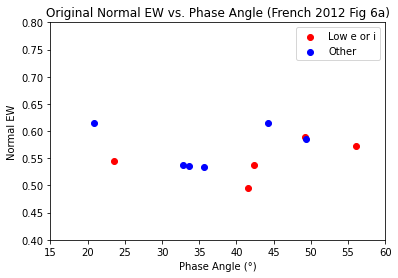

In [14]:
# Reproduce 2012 paper Fig 6a
# Look for dependence on e or i close to 90
low_e = np.abs(commondata['Mean Emission']-90) < 6
low_i = np.abs(commondata['Incidence']-90) < 6
low_ei = low_e | low_i
low_phase = commondata['Mean Phase'] <= 60
low_phase_commondata = commondata[low_phase]
mean_low = np.mean(low_phase_commondata['Normal EW_old'][low_ei])
mean_notlow = np.mean(low_phase_commondata['Normal EW_old'][~low_ei])
print('Mean Normal EW low E/I:', mean_low)
print('Mean Normal EW Other:', mean_notlow)
print('Ratio:', mean_notlow/mean_low)
plt.scatter(low_phase_commondata['Mean Phase'][low_ei], 
            low_phase_commondata['Normal EW_old'][low_ei], c='red', label='Low e or i')
plt.scatter(low_phase_commondata['Mean Phase'][~low_ei],
            low_phase_commondata['Normal EW_old'][~low_ei], c='blue', label='Other')
plt.legend()
plt.xlim(15,60)
plt.ylim(0.4,0.8)
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('Original Normal EW vs. Phase Angle (French 2012 Fig 6a)')

Mean Normal EW low E/I: 0.524984208
Mean Normal EW Other: 0.5087962899999999
Ratio: 0.9691649429576745


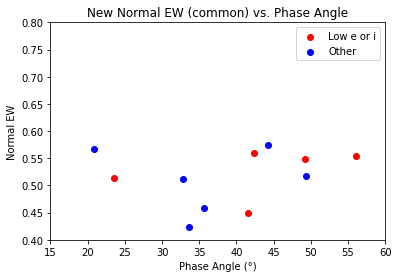

In [15]:
# Same figure but using new data
# Plot Normal EW for common new data for low phase angles and tag with
# low e or low i
low_e = np.abs(commondata['Mean Emission']-90) < 6
low_i = np.abs(commondata['Incidence']-90) < 6
low_ei = low_e | low_i
low_phase = commondata['Mean Phase'] <= 60
low_phase_commondata = commondata[low_phase]
mean_low = np.mean(low_phase_commondata['Normal EW'][low_ei])
mean_notlow = np.mean(low_phase_commondata['Normal EW'][~low_ei])
print('Mean Normal EW low E/I:', mean_low)
print('Mean Normal EW Other:', mean_notlow)
print('Ratio:', mean_notlow/mean_low)
plt.scatter(low_phase_commondata['Mean Phase'][low_ei], 
            low_phase_commondata['Normal EW'][low_ei], c='red', label='Low e or i')
plt.scatter(low_phase_commondata['Mean Phase'][~low_ei], 
            low_phase_commondata['Normal EW'][~low_ei], c='blue', label='Other')
plt.legend()
plt.xlim(15,60)
plt.ylim(0.4,0.8)
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('New Normal EW (common) vs. Phase Angle')

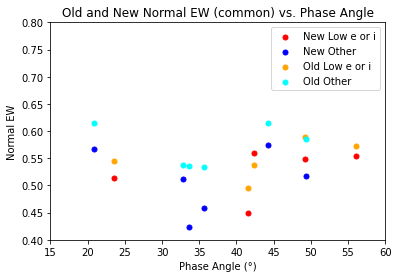

In [16]:
plt.scatter(low_phase_commondata['Mean Phase'][low_ei], 
            low_phase_commondata['Normal EW'][low_ei], marker='.', s=100, 
            c='red', label='New Low e or i')
plt.scatter(low_phase_commondata['Mean Phase'][~low_ei], 
            low_phase_commondata['Normal EW'][~low_ei], marker='.', s=100, 
            c='blue', label='New Other')
plt.scatter(low_phase_commondata['Mean Phase'][low_ei], 
            low_phase_commondata['Normal EW_old'][low_ei], marker='.', s=100, 
            c='orange', label='Old Low e or i')
plt.scatter(low_phase_commondata['Mean Phase'][~low_ei], 
            low_phase_commondata['Normal EW_old'][~low_ei], marker='.', s=100, 
            c='cyan', label='Old Other')
plt.legend()
plt.xlim(15,60)
plt.ylim(0.4,0.8)
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('Old and New Normal EW (common) vs. Phase Angle')